In [1]:
import wandb
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
from pathlib import Path
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_DATASET_PATH = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
TEST_DATASET_PATH = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_transforms = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(
        image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


train_ds = datasets.ImageFolder(root=TRAIN_DATASET_PATH, transform=train_transforms)
test_ds = datasets.ImageFolder(root=TEST_DATASET_PATH, transform=val_transforms)

In [4]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.to(DEVICE)

model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 95.7MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
from torch.optim.lr_scheduler import LambdaLR

BATCH_SIZE = 32
MODEL_NAME = "resnet152"
EPOCHS = 5
LEARNING_RATE = 1e-3

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"]
                               for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
eval_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
warmup_steps = 0.1 * len(train_loader)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: min(1., step / warmup_steps))
gradient_accumulation_steps = 4

In [6]:
wandb.login()
wandb.init(project="proyek-akhir-pcd", name="resnet152-5epoch-4gradaccumV2")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sulthanabiyyu. Use `wandb login --relogin` to force relogin


In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc=f"eval: ", leave=True)
        for pixel_values, labels in progress_bar:
            pixel_values, labels = pixel_values.to(DEVICE), labels.to(DEVICE)
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar.set_postfix(train_loss=loss.item())
            
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(loader), f1

step = 0
for epoch in range(EPOCHS):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for pixel_values, labels in progress_bar:
        pixel_values, labels = pixel_values.to(DEVICE), labels.to(DEVICE)

        # Forward and backward
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        # Logging with WANDB
        wandb.log({'Train Loss': loss.item()}, step=step)

        # Every 200 steps, perform evaluation
        if step % 200 == 0 and step > 1:
            eval_loss, eval_f1 = evaluate(model, eval_loader)
            wandb.log({'Eval Loss': eval_loss, 'Eval F1': eval_f1}, step=step)
        
        # Every 1200 steps, save a checkpoint
        if step % 1200 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss,
            }, f"checkpoint_{step}.pth")
        
        progress_bar.set_postfix(train_loss=loss.item())
        step += 1
        

wandb.finish()

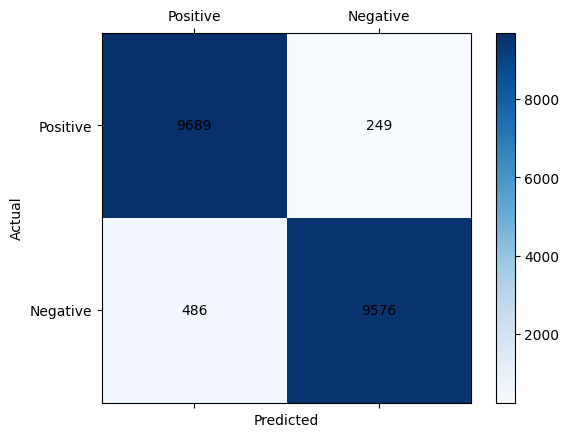

In [ ]:
import torch
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

saved_checkpoint = "./resnet-152-finetuned-cifake-epoch5/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(saved_checkpoint)
model = models.resnet152(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root=TEST_DATASET_PATH, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

all_preds = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())


true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())

tn, fp, fn, tp = confusion_matrix(true_labels, all_preds)


def plot_confusion_matrix(tp, tn, fp, fn):
    cm = np.array([[tp, fp], [fn, tn]])
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + ['Positive', 'Negative'])
    ax.set_yticklabels([''] + ['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center')

    plt.show()